![Logo Recolto](https://recolto.netlify.app/assets/logo_recolto_blanc.png)

Ce notebook a pour objectif d'explorer les données contenus dans les fichiers du modèle de simulation des schémas de surface (SAFRAN - Isba).

Focus sur le fichier de la période 2020 - 2024.

Auteur: Pierrick BERTHE

Source : https://www.data.gouv.fr/en/datasets/donnees-changement-climatique-sim-quotidienne/

Les objectifs de l'analyse sont les suivants:
- Vérifier la couverture géographique des points sélectionnés dans chaque grille.
- Comparer l’exactitude spatiale des points assignés aux deux grilles.
- Évaluer l’impact des choix de grille sur les valeurs météorologiques (précipitations).
- Analyser la cohérence des données temporelles entre les deux approches.

# <span style='background:grey'>Importations des librairies</span>

In [1]:
# General imports
import sys
from datetime import datetime
import time
import os

# Geographical imports
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

# Data manipulation imports
import pandas as pd
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt

# Versions
print("Interpréteur python :")
print("Python        : " + sys.version + "\n")
print("Version des librairies utilisées :")
print("Geopandas    : " + gpd.__version__)
print("Matplotlib   : " + mlp.__version__)
print("Numpy        : " + np.__version__)
print("Pandas       : " + pd.__version__)
# a compléter a la fin...

# Afficher heure lancement
maintenant = datetime.now().isoformat()
print("\nCode lance le : " + maintenant)

# Enregistrer l'heure de debut
start_time = time.time()

# Vérifiez le répertoire de travail actuel
print("\nCurrent working directory:", os.getcwd())

Interpréteur python :
Python        : 3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]

Version des librairies utilisées :
Geopandas    : 1.0.1
Matplotlib   : 3.10.0
Numpy        : 2.2.1
Pandas       : 2.2.3

Code lance le : 2025-02-10T21:48:12.188999

Current working directory: c:\Users\pierr\VSC_Projects\Recolto\notebooks


# <span style='background:grey'>Paramètres d'affichage</span>

In [2]:
# nombre ligne, col et chiffre apres la virgule
pd.set_option("display.max_row", 150)
pd.set_option("display.max_column", 150)
pd.set_option("display.precision", 2)

# <span style='background:grey'>Fonctions</span>

# <span style='background:grey'>Importation des données</span>

Importation fichier météo france

In [3]:
# path to the Meteo-France data
if os.getcwd().endswith("notebooks"):
    folder_path = "../.data/meteo_france"
    os.chdir(folder_path)
    print("New working directory:", os.getcwd())
else:
    pass

# Read the CSV file
file_name = "QUOT_SIM2_previous-2020-202412.csv"
df = pd.read_csv(file_name, sep=";", encoding="latin1")
print("File analyzed : ", file_name)
print("Dataframe shape:", df.shape)

New working directory: c:\Users\pierr\VSC_Projects\Recolto\.data\meteo_france
File analyzed :  QUOT_SIM2_previous-2020-202412.csv
Dataframe shape: (18072684, 28)


Importation fichier GeoJSON

In [4]:
# Path to the geojson data
if os.getcwd().endswith("meteo_france"):
    folder_path = "../../.data/france-drom"
    os.chdir(folder_path)
    print("New working directory:", os.getcwd())
else:
    pass

# Read the GeoJSON file
file_name = "regions.geojson"
gdf_region = gpd.read_file(file_name)
print("File analyzed:", file_name)
print("GeoDataFrame shape:", gdf_region.shape)

New working directory: c:\Users\pierr\VSC_Projects\Recolto\.data\france-drom
File analyzed: regions.geojson
GeoDataFrame shape: (18, 3)


# <span style='background:blue'>Etape 1 : Présentation dataset météo france</span>

## <span style='background:green'>1/ Aperçu tableau</span>

Nous affichons un apercu du début et de la fin du dataframe, ainsi que des lignes au hasard.

In [5]:
display(df)

,LAMBX,LAMBY,DATE,PRENEI_Q,PRELIQ_Q,T_Q,FF_Q,Q_Q,DLI_Q,SSI_Q,HU_Q,EVAP_Q,ETP_Q,PE_Q,SWI_Q,DRAINC_Q,RUNC_Q,RESR_NEIGE_Q,RESR_NEIGE6_Q,HTEURNEIGE_Q,HTEURNEIGE6_Q,HTEURNEIGEX_Q,SNOW_FRAC_Q,ECOULEMENT_Q,WG_RACINE_Q,WGI_RACINE_Q,TINF_H_Q,TSUP_H_Q
0,600,24010,20200101,0.0,0.4,9.9,2.1,7.41,3161.6,111.1,98.4,0.1,0.3,0.3,0.94,2.2,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.0,9.5,10.9
1,600,24010,20200102,0.0,0.6,11.3,5.5,7.40,2955.5,55.2,89.8,0.7,0.4,-0.1,0.93,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,9.5,11.9
2,600,24010,20200103,0.0,0.8,9.6,6.1,6.46,3066.2,56.5,87.2,1.0,0.7,-0.2,0.93,1.9,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,8.8,10.6
3,600,24010,20200104,0.0,0.0,8.1,2.7,5.23,2564.4,142.7,78.8,0.1,0.8,-0.1,0.92,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,5.4,10.2
4,600,24010,20200105,0.0,0.0,7.2,3.3,5.12,2774.9,115.8,81.9,0.3,1.1,-0.3,0.91,1.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.31,0.0,7.6,8.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18072679,11960,17450,20241227,0.0,0.0,8.5,3.7,3.87,2375.4,980.3,56.4,1.6,2.7,-1.6,0.93,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.33,0.0,5.6,15.7
18072680,11960,17450,20241228,0.0,0.0,9.8,1.7,3.89,2481.5,978.9,51.4,1.3,2.3,-1.3,0.92,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.0,5.7,17.9
18072681,11960,17450,20241229,0.0,0.0,9.5,1.4,4.42,2564.6,981.1,59.6,1.2,2.0,-1.2,0.91,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.0,5.8,16.9
18072682,11960,17450,20241230,0.0,0.0,9.5,1.5,5.61,2680.5,826.3,75.0,0.9,1.3,-0.9,0.90,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32,0.0,5.4,14.4


In [6]:
df.sample(5)

,LAMBX,LAMBY,DATE,PRENEI_Q,PRELIQ_Q,T_Q,FF_Q,Q_Q,DLI_Q,SSI_Q,HU_Q,EVAP_Q,ETP_Q,PE_Q,SWI_Q,DRAINC_Q,RUNC_Q,RESR_NEIGE_Q,RESR_NEIGE6_Q,HTEURNEIGE_Q,HTEURNEIGE6_Q,HTEURNEIGEX_Q,SNOW_FRAC_Q,ECOULEMENT_Q,WG_RACINE_Q,WGI_RACINE_Q,TINF_H_Q,TSUP_H_Q
16791604,5080,17610,20241021,0.0,3.6,13.4,1.3,7.95,2983.3,1119.4,75.8,2.0,2.3,1.6,0.89,0.3,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,8.5,20.7
12049274,7800,20490,20230111,0.0,1.3,5.5,2.2,5.04,2424.6,171.0,82.0,0.1,0.6,1.2,0.80,0.2,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.1,0.27,0.0,3.9,7.7
11832016,6840,18330,20230514,0.0,0.4,17.6,5.0,7.48,2812.9,1647.2,61.0,2.2,4.2,-1.8,0.44,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,13.5,21.1
10564253,9320,18330,20221002,0.0,0.0,22.6,6.3,9.00,2969.2,1888.3,54.0,0.5,6.8,-0.5,0.03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.17,0.0,18.5,28.3
4056714,4600,24650,20210202,0.0,15.5,11.2,4.7,7.53,2916.4,177.2,90.2,0.1,0.1,15.4,1.15,4.7,1.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.37,0.0,6.7,13.0


Il y a > 18 millions de lignes pour 28 colonnes.

## <span style='background:green'>2/ Structure</span>

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18072684 entries, 0 to 18072683
Data columns (total 28 columns):
 #   Column         Dtype  
---  ------         -----  
 0   LAMBX          int64  
 1   LAMBY          int64  
 2   DATE           int64  
 3   PRENEI_Q       float64
 4   PRELIQ_Q       float64
 5   T_Q            float64
 6   FF_Q           float64
 7   Q_Q            float64
 8   DLI_Q          float64
 9   SSI_Q          float64
 10  HU_Q           float64
 11  EVAP_Q         float64
 12  ETP_Q          float64
 13  PE_Q           float64
 14  SWI_Q          float64
 15  DRAINC_Q       float64
 16  RUNC_Q         float64
 17  RESR_NEIGE_Q   float64
 18  RESR_NEIGE6_Q  float64
 19  HTEURNEIGE_Q   float64
 20  HTEURNEIGE6_Q  float64
 21  HTEURNEIGEX_Q  float64
 22  SNOW_FRAC_Q    float64
 23  ECOULEMENT_Q   float64
 24  WG_RACINE_Q    float64
 25  WGI_RACINE_Q   float64
 26  TINF_H_Q       float64
 27  TSUP_H_Q       float64
dtypes: float64(25), int64(3)
memory usage: 3

Les 3 premières colonnes sont des entiers, les autres sont des float.

In [8]:
df.nunique()

LAMBX              142
LAMBY              134
DATE              1827
PRENEI_Q           952
PRELIQ_Q          1707
T_Q                537
FF_Q               199
Q_Q              17784
DLI_Q            23817
SSI_Q            33955
HU_Q               931
EVAP_Q             121
ETP_Q               91
PE_Q              1824
SWI_Q             1816
DRAINC_Q           564
RUNC_Q             608
RESR_NEIGE_Q     23805
RESR_NEIGE6_Q    23642
HTEURNEIGE_Q      7956
HTEURNEIGE6_Q     7993
HTEURNEIGEX_Q     8003
SNOW_FRAC_Q         11
ECOULEMENT_Q       844
WG_RACINE_Q        368
WGI_RACINE_Q       187
TINF_H_Q           526
TSUP_H_Q           621
dtype: int64

De nombreuses valeurs différentes sont présentes dans toutes les features. 

In [9]:
max(df.nunique())

33955

Aucune colonne ne semble être une clef primaire puisque la colonne ayant le plus de valeurs différentes en présente 34_000 différentes tandis q'il y a > 18 millions de lignes dans ce dataset.

## <span style='background:green'>3/ Valeurs manquantes</span>

In [10]:
nan_detected_sum = df.isna().sum().sum()
print(f"Nombre de valeurs manquantes : {nan_detected_sum}")

Nombre de valeurs manquantes : 0


Aucune valeur manquante.

## <span style='background:green'>4/ Doublons</span>

In [11]:
df.duplicated().sum()

np.int64(0)

Aucune ligne dupliquée.

## <span style='background:green'>5/ Inspection des données</span>

Résumé des features **quantitatives** :

In [12]:
df.describe().round(2)

,LAMBX,LAMBY,DATE,PRENEI_Q,PRELIQ_Q,T_Q,FF_Q,Q_Q,DLI_Q,SSI_Q,HU_Q,EVAP_Q,ETP_Q,PE_Q,SWI_Q,DRAINC_Q,RUNC_Q,RESR_NEIGE_Q,RESR_NEIGE6_Q,HTEURNEIGE_Q,HTEURNEIGE6_Q,HTEURNEIGEX_Q,SNOW_FRAC_Q,ECOULEMENT_Q,WG_RACINE_Q,WGI_RACINE_Q,TINF_H_Q,TSUP_H_Q
count,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07,1.81e+07
mean,6.55e+03,2.18e+04,2.02e+07,1.90e-01,2.42e+00,1.17e+01,2.82e+00,7.19e+00,2.82e+03,1.24e+03,7.72e+01,1.54e+00,2.36e+00,1.06e+00,6.50e-01,7.90e-01,3.00e-01,1.14e+01,1.14e+01,3.00e-02,3.00e-02,3.00e-02,4.00e-02,2.40e-01,2.70e-01,0.00e+00,8.37e+00,1.55e+01
std,2.43e+03,2.35e+03,1.42e+04,1.80e+00,5.61e+00,6.95e+00,1.68e+00,2.75e+00,3.37e+02,8.64e+02,1.29e+01,1.21e+00,1.84e+00,6.13e+00,2.80e-01,1.26e+00,1.03e+00,1.18e+02,1.18e+02,2.50e-01,2.50e-01,2.50e-01,1.50e-01,1.75e+00,5.00e-02,1.00e-02,6.44e+00,8.02e+00
min,6.00e+02,1.62e+04,2.02e+07,0.00e+00,0.00e+00,-2.15e+01,0.00e+00,2.90e-01,1.39e+03,1.96e+01,4.30e+00,-2.10e+00,0.00e+00,-1.00e+01,-4.00e-02,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,8.00e-02,0.00e+00,-2.27e+01,-2.06e+01
25%,4.68e+03,1.98e+04,2.02e+07,0.00e+00,0.00e+00,6.80e+00,1.60e+00,5.07e+00,2.61e+03,5.04e+02,6.94e+01,6.00e-01,9.00e-01,-1.70e+00,4.20e-01,3.00e-01,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,2.30e-01,0.00e+00,3.80e+00,9.90e+00
50%,6.44e+03,2.20e+04,2.02e+07,0.00e+00,1.00e-01,1.16e+01,2.40e+00,6.90e+00,2.86e+03,1.06e+03,7.94e+01,1.30e+00,1.80e+00,-5.00e-01,6.90e-01,4.00e-01,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,2.70e-01,0.00e+00,8.60e+00,1.52e+01
75%,8.44e+03,2.37e+04,2.02e+07,0.00e+00,2.20e+00,1.70e+01,3.60e+00,9.15e+00,3.07e+03,1.87e+03,8.70e+01,2.20e+00,3.40e+00,1.20e+00,8.80e-01,8.00e-01,2.00e-01,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,3.10e-01,0.00e+00,1.33e+01,2.13e+01
max,1.20e+04,2.68e+04,2.02e+07,3.15e+02,4.94e+02,3.34e+01,2.29e+01,2.03e+01,4.12e+03,3.45e+03,1.00e+02,1.38e+01,9.00e+00,4.90e+02,1.97e+00,2.09e+02,1.54e+02,9.05e+03,9.05e+03,1.54e+01,1.55e+01,1.55e+01,1.00e+00,1.44e+02,4.50e-01,1.90e-01,3.06e+01,4.27e+01


# <span style='background:blue'>Etape 2 : Présentation dataset GéoJSON</span>

## <span style='background:green'>1/ Aperçu tableau</span>

Nous affichons un apercu du début et de la fin du dataframe, ainsi que des lignes au hasard.

In [13]:
display(gdf_region)

,code,nom,geometry
0,11,Île-de-France,"POLYGON ((1.92215 48.4576, 1.92074 48.44775, 1..."
1,24,Centre-Val de Loire,"POLYGON ((0.81482 48.67016, 0.82767 48.68072, ..."
2,27,Bourgogne-Franche-Comté,"POLYGON ((6.94054 47.43337, 6.94168 47.4158, 6..."
3,28,Normandie,"POLYGON ((-1.11962 49.35557, -1.11503 49.3624,..."
4,32,Hauts-de-France,"POLYGON ((4.14089 49.97876, 4.15398 49.97484, ..."
5,44,Grand Est,"POLYGON ((3.41479 48.39027, 3.42208 48.41334, ..."
6,52,Pays de la Loire,"MULTIPOLYGON (((-2.30479 46.70942, -2.28612 46..."
7,53,Bretagne,"MULTIPOLYGON (((-2.12371 48.60441, -2.13448 48..."
8,75,Nouvelle-Aquitaine,"MULTIPOLYGON (((-1.02574 45.57469, -0.993 45.5..."
9,01,Guadeloupe,"MULTIPOLYGON (((-61.63356 15.83977, -61.64798 ..."


## <span style='background:green'>2/ Structure</span>

In [14]:
gdf_region.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   code      18 non-null     object  
 1   nom       18 non-null     object  
 2   geometry  18 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 564.0+ bytes


In [15]:
gdf_region.nunique()

code        18
nom         18
geometry    18
dtype: int64

## <span style='background:green'>3/ Valeurs manquantes</span>

In [16]:
nan_detected_sum = gdf_region.isna().sum().sum()
print(f"Nombre de valeurs manquantes : {nan_detected_sum}")

Nombre de valeurs manquantes : 0


## <span style='background:green'>4/ Doublons</span>

In [17]:
gdf_region.duplicated().sum()

np.int64(0)

## <span style='background:green'>5/ Inspection des données</span>

Résumé des features **quantitatives** :

In [18]:
gdf_region.describe().round(2)

,code,nom,geometry
count,18,18,18
unique,18,18,18
top,11,Île-de-France,"POLYGON ((1.9221462784913 48.457599361977, 1.9..."
freq,1,1,1


# <span style='background:blue'>Etape 3 : Nettoyage du dataset météo france</span>

## <span style='background:green'>1/ Filtrage des colonnes</span>

Nous focalisons sur les colonnes suivantes qui nous interressent pour le projet recolto :
- **'LAMBX'** : E en Lambert II étendu (en hm)
- **'LAMBY'** : N en Lambert II étendu (en hm)
- **DATE'** : Date de l'observation (en AAAAMMJJ)
- ~~**PRENEI_Q** : Précipitations solides (en mm)~~
- **PRELIQ_Q** : Précipitations liquides  (en mm)
- ~~**PE_Q** : Pluies efficaces  (en mm)~~

Les précipitations solides sont exclues car il s'agit de la neige, bien que cette neige qui fondra sur un toit pourrait être récupérée par un système de récupération d'eau de pluie. Mais nous l'excluerons pour le moment.

Les pluies efficaces sont exclues car elles correspondent aux précipitations qui contribuent réellement à alimenter les milieux aquatiques et à recharger les nappes souterraines.
Source : https://www.eaufrance.fr/les-precipitations-efficaces

Nous les isolons et nous observons leur distribution.

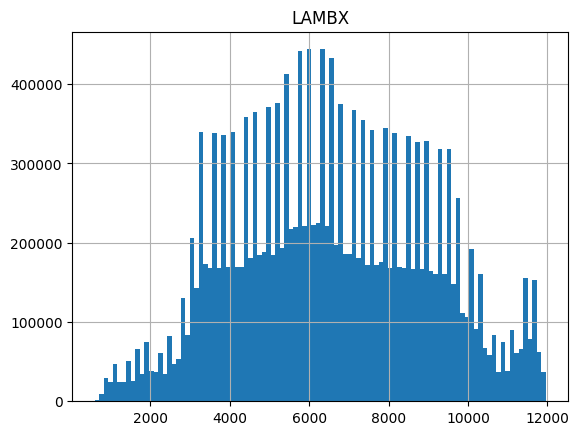

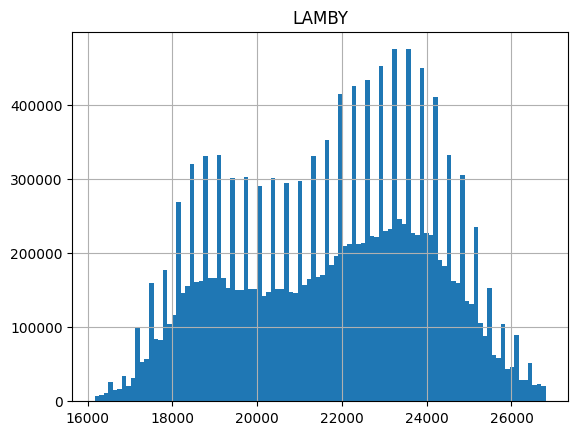

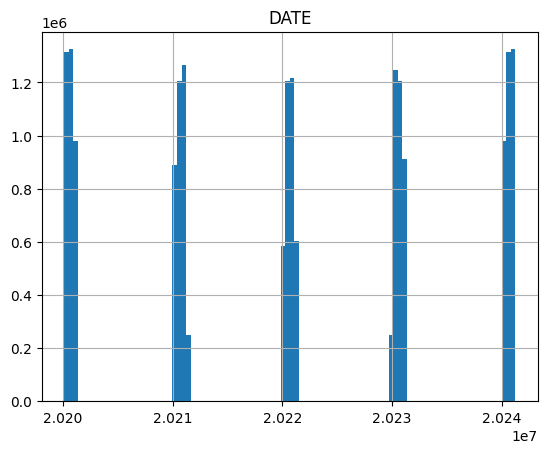

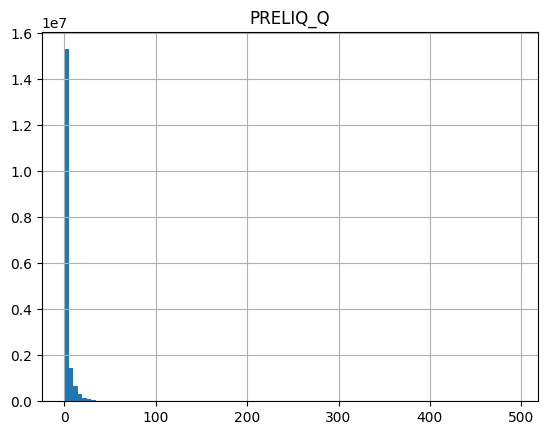

In [19]:
# Isolate the columns of interest
interest_col = ['LAMBX', 'LAMBY', 'DATE', 'PRELIQ_Q']
df_filtred = df[interest_col]

#Plot distribution
for col in df_filtred.columns:
    df_filtred.hist(column=col, bins=100)

Les variables LAMBX et LAMBY ne sont pas au format habituelle en mètre mais leurs valeurs correspondent aux valeurs habituellement fournies pour les coordonnées géographiques de la France en Lambert II étendu. Voir schéma ci-dessous : 

![Carte france lambert 2 etendu](https://geofree.fr/img/maps/lamb2E_carte_WM.png)

Il faut noter egalement que le format de la date est au format AAAAMMJJ comme un simple string. Il faudra le convertir en datetime pour pouvoir l'utiliser correctement.

## <span style='background:green'>2/ Conversion valeurs en unité cohérentes</span>

### <span style='background:purple'>a/ LAMBX et LAMBY</span>

Passage des hectomètre -> mètre (x 100)

In [20]:
# Conversion hm to m (x 100)
df_lamb_ok = df_filtred.copy()
df_lamb_ok[['LAMBX', 'LAMBY']] = df_filtred[['LAMBX', 'LAMBY']] * 100

### <span style='background:purple'>b/ Date</span>

Passage du format string -> datetime

In [21]:
# Conversion date to datetime
df_date_ok = df_lamb_ok.copy()
df_date_ok['DATE'] = pd.to_datetime(df_lamb_ok['DATE'], format='%Y%m%d')

Nous vérifions à nouveau la distribution des valeurs des 3 premières colonnes.

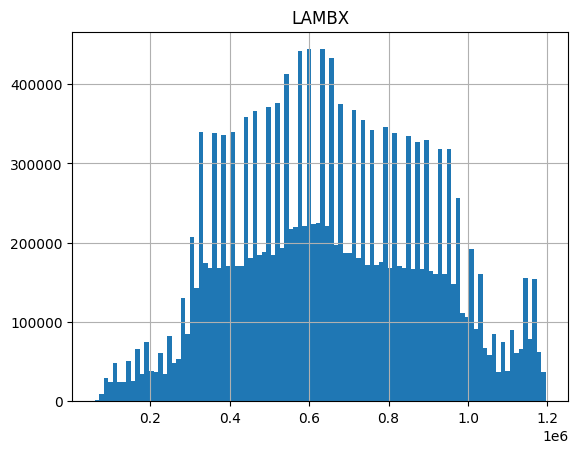

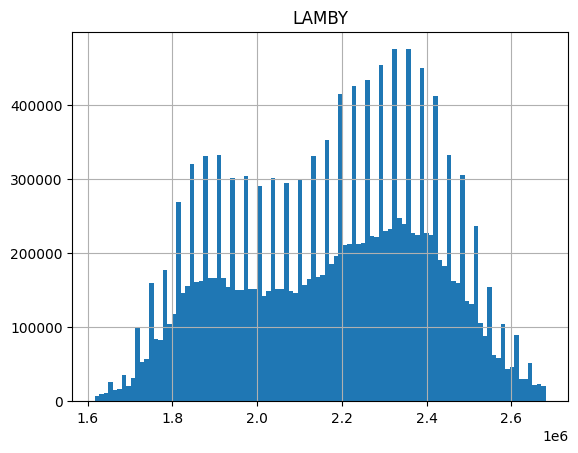

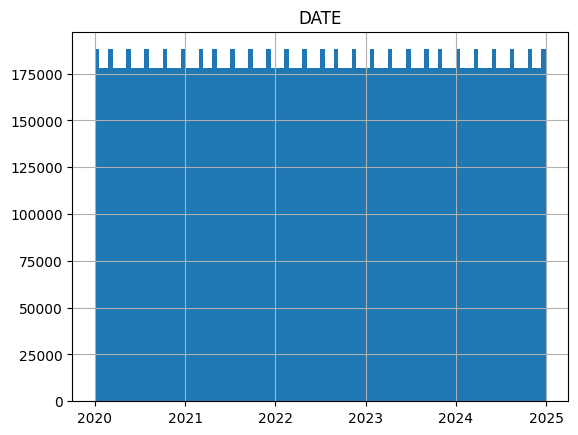

In [22]:
#Plot distribution
for col in df_date_ok.columns[:3]:
    df_date_ok.hist(column=col, bins=100)

Ainsi qu'un apreçu rapide du tableau netttoyé.

In [23]:
display(df_date_ok)

,LAMBX,LAMBY,DATE,PRELIQ_Q
0,60000,2401000,2020-01-01,0.4
1,60000,2401000,2020-01-02,0.6
2,60000,2401000,2020-01-03,0.8
3,60000,2401000,2020-01-04,0.0
4,60000,2401000,2020-01-05,0.0
...,...,...,...,...
18072679,1196000,1745000,2024-12-27,0.0
18072680,1196000,1745000,2024-12-28,0.0
18072681,1196000,1745000,2024-12-29,0.0
18072682,1196000,1745000,2024-12-30,0.0


# <span style='background:blue'>Etape 4 : Nettoyage du dataset GeoJSON</span>

Nous séparons la france métropolitaine et les dom-tom.

In [25]:
dom_tom = ['Guadeloupe', 'Martinique', 'Guyane', 'La Réunion', 'Mayotte']
gdf_dom_tom = gdf_region[gdf_region['nom'].isin(dom_tom)]
gdf_region_metro = gdf_region[~gdf_region['nom'].isin(dom_tom)]

Conversion des coordonnées en Lambert II étendu en coordonnées géographiques (longitude et latitude).

In [26]:
gdf_region_metro = gdf_region_metro.to_crs(epsg=3857)

# <span style='background:blue'>Etape 5 : Comparaison Meteo France / GeoJSON</span>

Nous affichons tout d'abord la position des points de collecte sur une carte de France. Pour cela, nous isolons toutes les combinaisons uniques de LAMBX et LAMBY.

All LAMBX & LAMBY combination : 9892 dots


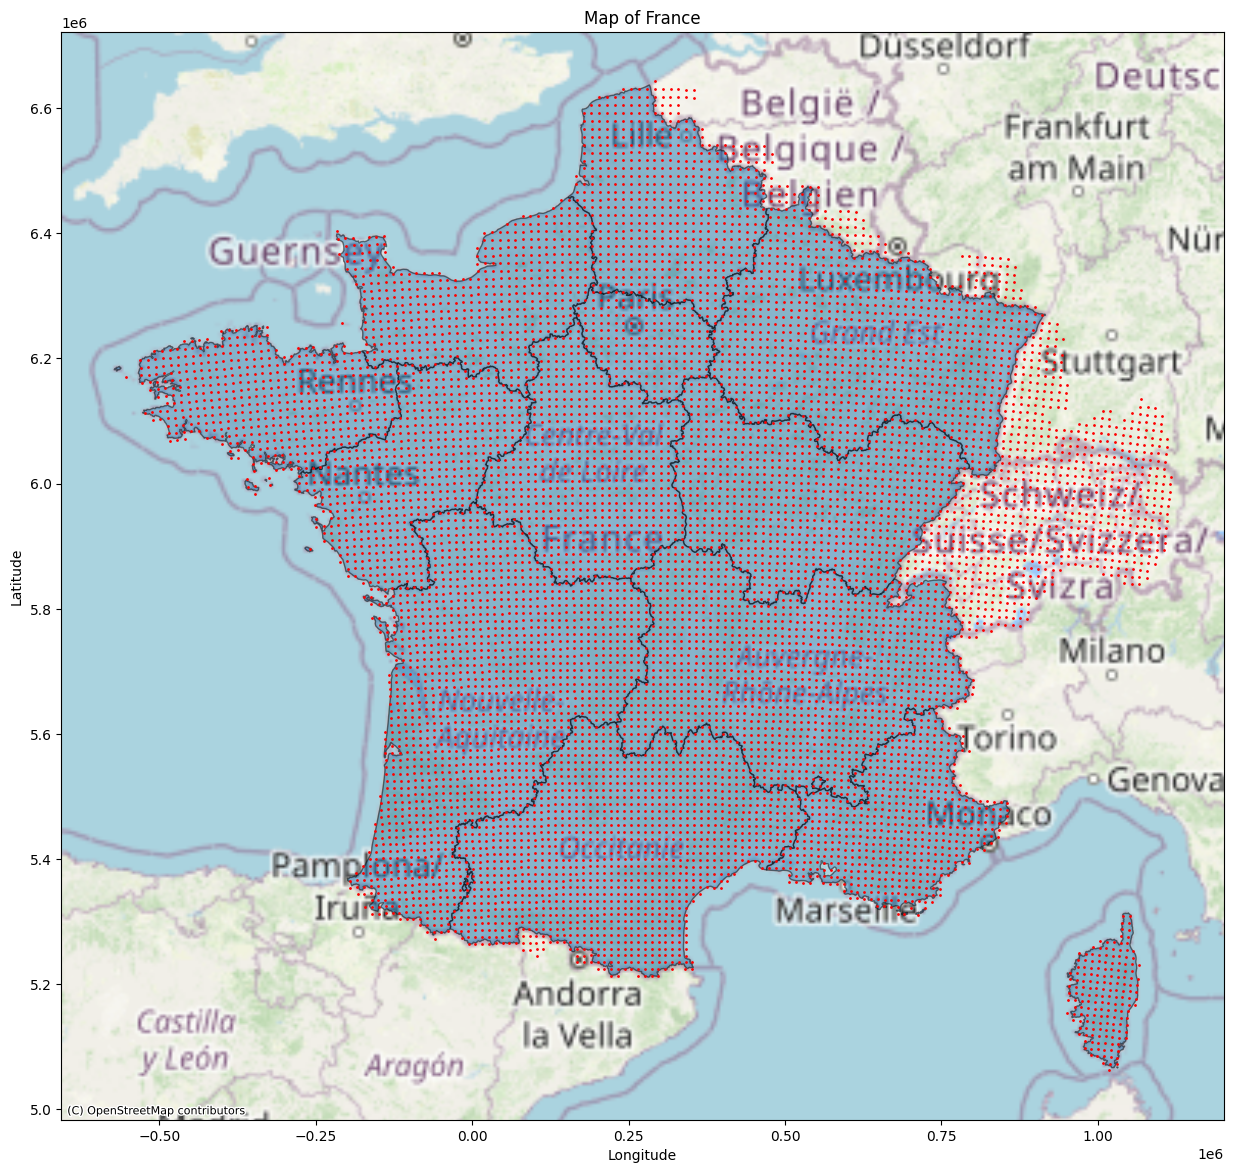

In [27]:
# Lambert II extended column isolation
df_lamb = df_date_ok.loc[:, ['LAMBX', 'LAMBY']]

# Remove duplicates
df_lamb_unique = df_lamb.drop_duplicates()
print(f"All LAMBX & LAMBY combination : {len(df_lamb_unique)} dots")

# Convert coordinates to Point geometry objects
geometry = [
    Point(xy) for xy in zip(df_lamb_unique['LAMBX'], df_lamb_unique['LAMBY'])
]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(df_lamb_unique, geometry=geometry)

# Define the coordinate system (EPSG:27572 for Lambert II extended)
gdf.crs = 'EPSG:27572'

# Convert to EPSG:3857 for display with contextily
gdf = gdf.to_crs(epsg=3857)

# Create the map and dots
fig, ax = plt.subplots(figsize=(15, 15))

# Plot regions
gdf_region_metro.plot(ax=ax, alpha=0.5, edgecolor='k')

# Plot points
gdf.plot(ax=ax, marker='o', color='red', markersize=1)

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=5)

# Display the map
plt.title('Map of France')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Nous remarquons que les points de collecte sont répartis sur l'ensemble du territoire français, mais également de la Suisse et de tous petits territoires en Belgique et en Allemagne. 

<div class="alert alert-block alert-success"><b>Bilan: </b>

Le fichier **'QUOT_SIM2_previous-2020-202412.csv'** contient des informations quotidiennes sur 25 paramètres pour 9_892 points de la France métropolitaine et de la Suisse sur la période 2020 à 2024. Nous pouvons utiliser la variable **'PRELIQ_Q'** pour estimer les précipitations liquides sur chaque point de collecte.


# <span style='background:blue'>Etape 6 : Comparaison Meteo France / GeoJSON / Copernicus</span>

Nous comparons les points de collecte Copernicus en plus

In [29]:
# path to the copernicus data
if os.getcwd().endswith("france-drom"):
    folder_path = "../copernicus"
    os.chdir(folder_path)
    print("New working directory:", os.getcwd())
else:
    pass

# Read the CSV file
file_name = "centroid_coordinates_all.json"
df_copernicus = pd.read_json(file_name)
print("File analyzed : ", file_name)
print("Dataframe shape:", df.shape)

File analyzed :  centroid_coordinates_all.json
Dataframe shape: (1789, 3)


In [30]:
display(df_copernicus)

,gid,lng,lat
0,1,55.5,-21.3
1,2,55.7,-21.3
2,3,55.3,-21.1
3,4,55.5,-21.1
4,5,55.7,-21.1
...,...,...,...
1784,1785,1.7,50.9
1785,1786,1.9,50.9
1786,1787,2.1,50.9
1787,1788,2.3,50.9


Nous supprimmons la colonne 'gid'

In [34]:
df_copernicus.pop("gid")
display(df_copernicus)

,lng,lat
0,55.5,-21.3
1,55.7,-21.3
2,55.3,-21.1
3,55.5,-21.1
4,55.7,-21.1
...,...,...
1784,1.7,50.9
1785,1.9,50.9
1786,2.1,50.9
1787,2.3,50.9


In [ ]:
# Convert coordinates to Point geometry objects
geometry = [
    Point(xy) for xy in zip(df_copernicus['lng'], df_copernicus['lat'])
]

# Create GeoDataFrame
gdf_copernicus = gpd.GeoDataFrame(df_copernicus, geometry=geometry)

# Define the coordinate system (EPSG:4326 for WGS 84)
gdf_copernicus.crs = 'EPSG:4326'

# COnversion to EPSG:3857 for display with contextily
gdf_copernicus = gdf_copernicus.to_crs(epsg=3857)
display(gdf_copernicus)

,lng,lat,geometry
0,55.5,-21.3,POINT (6178232.184 -2427686.544)
1,55.7,-21.3,POINT (6200495.637 -2427686.544)
2,55.3,-21.1,POINT (6155967.841 -2403806.283)
3,55.5,-21.1,POINT (6178232.184 -2403806.283)
4,55.7,-21.1,POINT (6200495.637 -2403806.283)
...,...,...,...
1784,1.7,50.9,POINT (189243.301 6603624.789)
1785,1.9,50.9,POINT (211507.7 6603624.789)
1786,2.1,50.9,POINT (233771.265 6603624.789)
1787,2.3,50.9,POINT (256034.829 6603624.789)


Nous affichons les points de collecte sur une carte de France.

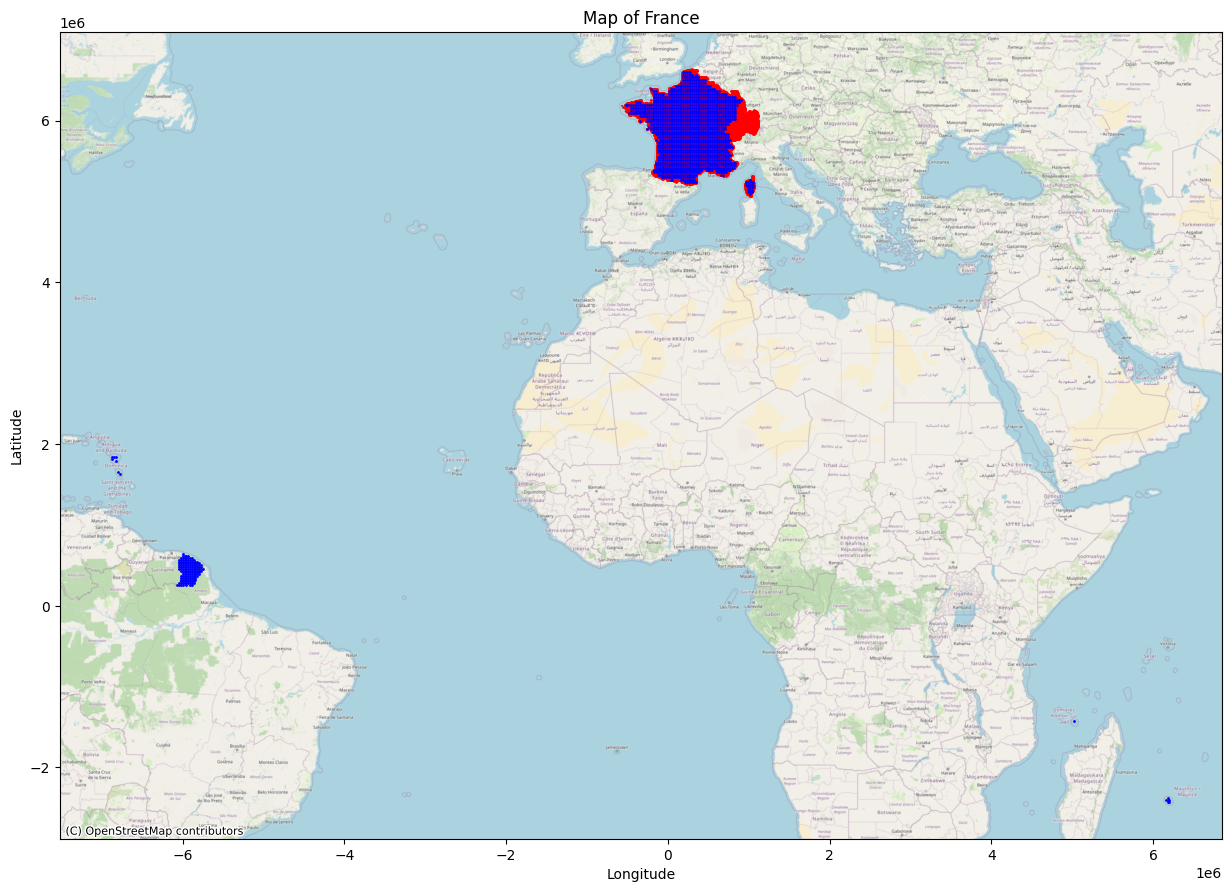

In [46]:
# Create the map and dots
fig, ax = plt.subplots(figsize=(15, 15))

# Plot regions GEOJSON
gdf_region_metro.plot(ax=ax, alpha=0.5, edgecolor='k')

# Plot points meteo france (rouge)
gdf.plot(ax=ax, marker='o', color='red', markersize=1)

# plot points copernicus (bleu)
gdf_copernicus.plot(ax=ax, marker='o', color='blue', markersize=1)

# Add a basemap
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=5)

# Display the map
plt.title('Map of France')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Les points de collecte Copernicus comprennent les dom-tom en plus de la France métropolitaine. 